In [1]:
# %reset

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import math
import datetime 
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy.stats import describe
from pylab import plt, mpl
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot
import random

In [57]:
from arch import arch_model
import matrix_optimize
from matrix_optimize import port_ret, port_vol, min_vol, eff_vol, sharpe_ratio, efficient_frontier, tangent_portfolio

In [58]:
plt.style.use('seaborn')

In [59]:
mydict = {'IGF': 'Global Infrastructure', 
          'IFGL':'International Developed Real Estate ETF',
          'IXN': 'iShares Global Tech ETF',
          'IXJ': 'iShares Global Healthcare ETF',
          'VDE': 'Vanguard Energy ETF',
          'KXI': 'iShares Global Consumer Staples ETF',
          'SPGP':'iShares Gold Producers UCITS ETF',
          'VIS': 'Vanguard Industrial ETF',
          'RXI': 'iShares Global Consumer Discretionary ETF'
         }
# List shares of interest as Yahoo Fiance "Ticker"/"Symbol"
mylist = list(mydict)[:]
noa = len(mylist)

# Load Data
rets = pd.read_excel(r'C:\Users\Ma-Bi\OneDrive\Kandidat\Topics in Financial Econometrics - Seminar\log_rets.xlsx', 
                   sheet_name='Sheet', index=True, index_col=[0])
rets.head()

,IGF,IFGL,IXN,IXJ,VDE,KXI,SPGP,VIS,RXI
Date,,,,,,,,,
2012-01-04,-0.535872,-0.231571,-0.016714,-0.615608,0.298946,-0.716318,-0.200287,0.425633,0.019647
2012-01-05,-0.959820,-0.931686,0.150258,-0.247318,-0.424549,-0.555680,0.000000,0.125751,0.000000
2012-01-06,-1.273904,-1.137487,-0.217101,-0.194751,-0.611118,-0.862134,0.649500,-0.141489,-0.039307
2012-01-09,0.578314,0.589956,-0.100376,0.123992,0.378746,0.273061,-0.249316,0.783575,0.450934
2012-01-10,1.146669,1.672213,0.334160,0.494343,0.858938,0.694436,0.993525,1.410559,0.876437


In [60]:
TABLE = rets.describe()[1:3].round(3).transpose()
TABLE['skewness'] = np.array(rets.skew().round(3))
TABLE['kurtosis'] = np.array(rets.kurt().round(3))
TABLE['ticker'] = np.array(list(mydict)[:])
TABLE = TABLE[['ticker', 'mean', 'std', 'skewness', 'kurtosis']]
TABLE = TABLE.set_index(np.array(list(mydict.values())[:]))
display(TABLE)
# print(TABLE.to_latex(index=True))

,ticker,mean,std,skewness,kurtosis
Global Infrastructure,IGF,0.029,0.782,-0.437,2.683
International Developed Real Estate ETF,IFGL,0.029,0.842,-0.442,4.053
iShares Global Tech ETF,IXN,0.063,1.015,-0.438,2.877
iShares Global Healthcare ETF,IXJ,0.048,0.827,-0.354,2.035
Vanguard Energy ETF,VDE,-0.003,1.288,-0.204,2.025
iShares Global Consumer Staples ETF,KXI,0.034,0.688,-0.436,2.280
iShares Gold Producers UCITS ETF,SPGP,0.059,0.909,-0.345,4.223
Vanguard Industrial ETF,VIS,0.050,0.937,-0.424,2.123
iShares Global Consumer Discretionary ETF,RXI,0.050,0.887,-0.494,2.781


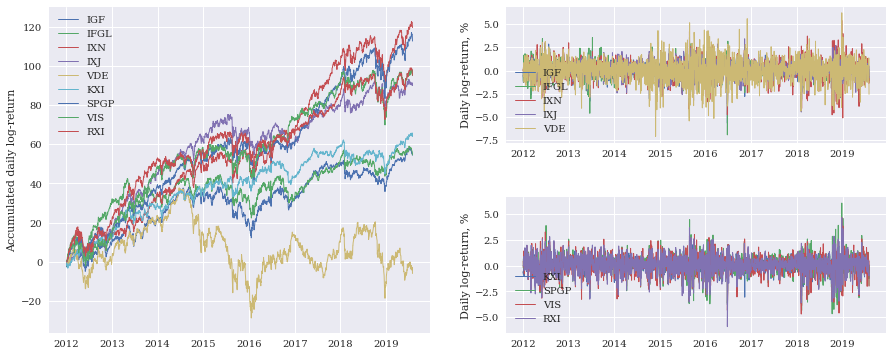

In [61]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)

mpl.rcParams['font.family'] = 'serif'
#%matplotlib inline

plt.subplot(1, 2, 1)
plt.plot(rets.cumsum(), lw=1.0)
plt.ylabel('Accumulated daily log-return')
plt.legend(list(mydict))

plt.subplot(2, 2, 2)
plt.plot(rets.iloc[:, 0:5], lw=1.0)
plt.ylabel('Daily log-return, %')
plt.legend(list(mydict)[0:5])


plt.subplot(2, 2, 4)
plt.plot(rets.iloc[:, 5:], lw=1.0)
plt.ylabel('Daily log-return, %')
plt.legend(list(mydict)[5:])

#plt.show()
plt.savefig('historic_development.png', dpi=300, bbox_inches='tight')

In [62]:
# Random assigned weight
weights = np.random.random(noa)
weights /= np.sum(weights) 
weights

array([0.16504325, 0.04222611, 0.20712654, 0.17448689, 0.06059069,
       0.0124542 , 0.10232248, 0.03123698, 0.20451287])

In [63]:
print('Covariance Matrix \n')
print(np.round(rets.cov(), 2).to_latex())
# plt.matshow(rets.cov(), cmap='coolwarm')
# plt.show()

Covariance Matrix 

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &   IGF &  IFGL &   IXN &   IXJ &   VDE &   KXI &  SPGP &   VIS &   RXI \\
\midrule
IGF  &  0.61 &  0.52 &  0.54 &  0.45 &  0.67 &  0.42 &  0.44 &  0.51 &  0.52 \\
IFGL &  0.52 &  0.71 &  0.57 &  0.46 &  0.60 &  0.42 &  0.45 &  0.52 &  0.56 \\
IXN  &  0.54 &  0.57 &  1.03 &  0.62 &  0.77 &  0.47 &  0.79 &  0.76 &  0.76 \\
IXJ  &  0.45 &  0.46 &  0.62 &  0.68 &  0.58 &  0.42 &  0.57 &  0.57 &  0.57 \\
VDE  &  0.67 &  0.60 &  0.77 &  0.58 &  1.66 &  0.45 &  0.66 &  0.83 &  0.72 \\
KXI  &  0.42 &  0.42 &  0.47 &  0.42 &  0.45 &  0.47 &  0.40 &  0.44 &  0.46 \\
SPGP &  0.44 &  0.45 &  0.79 &  0.57 &  0.66 &  0.40 &  0.83 &  0.66 &  0.66 \\
VIS  &  0.51 &  0.52 &  0.76 &  0.57 &  0.83 &  0.44 &  0.66 &  0.88 &  0.70 \\
RXI  &  0.52 &  0.56 &  0.76 &  0.57 &  0.72 &  0.46 &  0.66 &  0.70 &  0.79 \\
\bottomrule
\end{tabular}



In [68]:
# Monte Carlo simulation

p_rets = []
p_vols = []
    
for p in range (50000):
    weights = np.random.random(noa)
    weights /= np.sum(weights) 
    p_rets.append(port_ret(mu=rets.mean(),weights=weights))
    p_vols.append(port_vol(omega=rets.cov(),weights=weights))
    
p_rets = np.array(p_rets)
p_vols = np.array(p_vols)

# MATRIX


## Historically based minimum vol portfolio

In [69]:
# a. Find minimum variance weights
hist_w_min = matrix_optimize.min_vol(noa=noa, omega=rets.cov())

# b. Compute annualized portfolio return
hist_ret_min = port_ret(mu=rets.mean(),weights=hist_w_min)

# c. Compute annualized portfolio volatility
hist_vol_min = port_vol(omega=rets.cov(),weights=hist_w_min)

# d. Print results:
print('Minimum vol weights', hist_w_min)
print('Annualized portfolio return = ', hist_ret_min.round(3))
print('Annualized portfolio vol = ', hist_vol_min.round(3))
print('Maximum Sharpe Ratio = ',(hist_ret_min/hist_vol_min).round(3),
      '=', -sharpe_ratio(mu=rets.mean(), omega=rets.cov(),weights=hist_w_min).round(3))

Minimum vol weights [ 0.196  0.143 -0.234  0.099 -0.058  0.648  0.299  0.072 -0.164]
Annualized portfolio return =  8.766
Annualized portfolio vol =  10.424
Maximum Sharpe Ratio =  0.841 = 0.841


## Historically based efficient portfolio - given target return

In [70]:
# a. Find efficient weights given target return
hist_w_eff = matrix_optimize.eff_vol(noa=noa, omega=rets.cov(), mu=rets.mean(), target_return=30/252)

# b. Compute annualized portfolio return
hist_ret_eff = port_ret(mu=rets.mean(),weights=hist_w_eff)

# c. Compute annualized portfolio volatility
hist_vol_eff = port_vol(omega=rets.cov(),weights=hist_w_eff)

# d. Print resuts:
print('Efficient weights', hist_w_eff)
print('Annualized portfolio return = ', hist_ret_eff.round(3))
print('Annualized portfolio vol = ', hist_vol_eff.round(3))
print('Maximum Sharpe Ratio = ',(hist_ret_eff/hist_vol_eff).round(3),
      '=', -sharpe_ratio(mu=rets.mean(), omega=rets.cov(),weights=hist_w_eff).round(3))

Efficient weights [ 0.343 -0.441  0.465  0.279 -1.032 -0.064  0.628  0.623  0.198]
Annualized portfolio return =  29.989
Annualized portfolio vol =  21.235
Maximum Sharpe Ratio =  1.412 = 1.412


# Effecient frontier

In [71]:
hist_z, hist_front_vol, hist_front_ret = efficient_frontier(min_weights=hist_w_min,
                                                   eff_weights=hist_w_eff, omega=rets.cov(), mu=rets.mean())

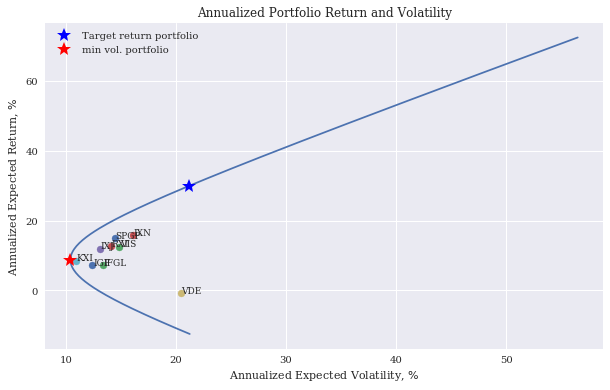

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

plt.plot(hist_front_vol, hist_front_ret)

plt.plot(hist_vol_eff, hist_ret_eff, 'b*', markersize=15.0, label='Target return portfolio')
plt.plot(hist_vol_min, hist_ret_min, 'r*', markersize=15.0, label='min vol. portfolio')

# plot individual ETFs
for i,type in enumerate(mylist):
    x2 = np.sqrt((rets[type]).var()*252)
    y2 = rets[type].mean()*252
    plt.scatter(x2, y2, marker='o')  
    plt.text(x2+0.05, y2+0.05, type, fontsize=9)
    
plt.xlabel('Annualized Expected Volatility, $\%$')
plt.ylabel('Annualized Expected Return, $\%$')
plt.title('Annualized Portfolio Return and Volatility')

plt.legend()
plt.show()

## Tangent Portfolio

In [73]:
opt, evols, erets, f_tangent = tangent_portfolio(front_vol=hist_front_vol, front_ret=hist_front_ret)

Optimal parameter values =  [ 0.      1.4226 17.6033]
Check that eq holds: [ 0.  0. -0.]


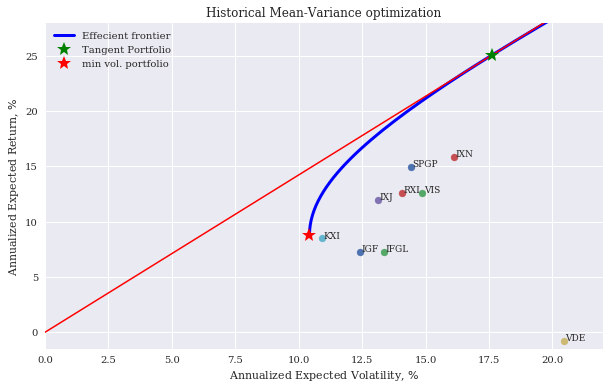

In [74]:
rf=0
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

plt.plot(evols, erets, 'b', lw=3.0, label='Effecient frontier')

cx = np.linspace(0.0, 20.0)
plt.plot(cx, opt[0] + opt[1] * cx, 'r', lw=1.5)

plt.plot(opt[2], f_tangent, 'g*', markersize=15, label='Tangent Portfolio')
plt.plot(hist_vol_min, hist_ret_min, 'r*', markersize=15.0, label='min vol. portfolio')

# plot individual ETFs
for i,type in enumerate(mylist):
    x2 = np.sqrt((rets[type]).var()*252)
    y2 = rets[type].mean()*252
    plt.scatter(x2, y2, marker='o')  
    plt.text(x2+0.05, y2+0.05, type, fontsize=9)


plt.grid(True)
axes = plt.gca()
axes.set_xlim([0,22])
axes.set_ylim([-1.5,28])
plt.xlabel('Annualized Expected Volatility, $\%$')
plt.ylabel('Annualized Expected Return, $\%$')
plt.title('Historical Mean-Variance optimization')
plt.legend()

plt.savefig('tangent_port.png', dpi=300, bbox_inches='tight')

In [75]:
# a. Find tangent portfolio weight
ind = np.where(np.array(hist_front_vol.round(1)==opt[2].round(1)))[0][0]
hist_w_tan = hist_z[ind]

# b. Compute annualized portfolio return
hist_ret_tan = port_ret(mu=rets.mean(),weights=hist_w_tan)

# c. Compute annualized portfolio volatility
hist_vol_tan = port_vol(omega=rets.cov(),weights=hist_w_tan)

# d. Print resuts:
print('Efficient weights', hist_w_tan.round(3))
print('Annualized portfolio return = ', hist_ret_tan.round(3))
print('Annualized portfolio vol = ', hist_vol_tan.round(3))
print('Maximum Sharpe Ratio = ',(hist_ret_tan/hist_vol_tan).round(3),
      '=', -sharpe_ratio(mu=rets.mean(), omega=rets.cov(),weights=hist_w_tan).round(3))

Efficient weights [ 0.309 -0.306  0.303  0.237 -0.807  0.101  0.552  0.496  0.114]
Annualized portfolio return =  25.083
Annualized portfolio vol =  17.632
Maximum Sharpe Ratio =  1.423 = 1.423



# Conclusion

In [77]:
# Weights: minimum vol, max Sharpe
conc_1 = np.vstack([mylist, hist_w_min.round(3)])
conc_1 = np.vstack([conc_1, hist_w_eff.round(3)])
conc_1 = np.vstack([conc_1, hist_w_tan.round(3)])

# Portfolio return
P_R_1 = np.ones(4)
P_R_1[1:] = np.array([hist_ret_min , hist_ret_eff, hist_ret_tan]).round(3)
conc_1 = np.column_stack((conc_1, P_R_1))

# Portfolio volatility
P_V_1 = np.ones(4)
P_V_1[1:] = np.array([hist_vol_min , hist_vol_eff, hist_vol_tan]).round(3)
conc_1 = np.column_stack((conc_1, P_V_1))

# Portfolio Sharpe Ratio
P_SR_1 = np.ones(4)
P_SR_1[1:] = np.array([-sharpe_ratio(mu=rets.mean(), omega=rets.cov(),weights=hist_w_min),
                       -sharpe_ratio(mu=rets.mean(), omega=rets.cov(),weights=hist_w_eff), 
                       -sharpe_ratio(mu=rets.mean(), omega=rets.cov(),weights=hist_w_tan)]).round(3)
conc_1 = np.column_stack((conc_1, P_SR_1))

conc_1 = pd.DataFrame(conc_1, index=['Ticker', 'Minimum vol. portfolio', 
                                     'Target return portfolio', 'Tangent portfolio'])


conc_1.columns = conc_1.iloc[0]
conc_1 = conc_1.drop(conc_1.index[0])
conc_1.columns.values[[-3, -2, -1]] = ['Exp. return', 'Exp. volatility', 'Exp. SR']
conc_1

Ticker,IGF,IFGL,IXN,IXJ,VDE,KXI,SPGP,VIS,RXI,Exp. return,Exp. volatility,Exp. SR
Minimum vol. portfolio,0.196,0.143,-0.234,0.099,-0.058,0.648,0.299,0.072,-0.164,8.766,10.424,0.841
Target return portfolio,0.343,-0.441,0.465,0.279,-1.032,-0.064,0.628,0.623,0.198,29.989,21.235,1.412
Tangent portfolio,0.309,-0.306,0.303,0.237,-0.807,0.101,0.552,0.496,0.114,25.083,17.632,1.423


## Moving on to GARCH modelleing

In [78]:
n_time = 100
n_test = 30
H = -n_time+n_test


parameters = np.zeros((noa,4))
forecasts = np.zeros((noa,n_test))
forecast_variance = np.zeros(noa)
std_resid = np.zeros((noa,len(rets['IGF'][:-n_time])))



for i,n in enumerate(mylist):
    # split into train/test = in-sample/out-of-sample
    train, test = rets[n][:-n_time], rets[n][-n_time : H] 

    # define GARCH model
    model = arch_model(train, mean='Constant', vol='GARCH', p=1, q=1)
    # model = arch_model(train, p=1, o=1, q=1) # GJR Garch - just change parameters to 5 instead of 4

    # fit model
    res = model.fit(disp='off')

    # Save parameter estimates
    parameters[i][:] = res.params[:]
    
    # Save standardized residuals
    std_resid[i][:] = res.resid / res.conditional_volatility
    
    # forecast variance
    forecasts[i][:] = res.forecast(horizon=n_test).variance.dropna().values.T[:,0]
    forecast_variance[i] = forecasts[i].mean() # Each asset's forecasted variance for period n_test period ahead

## Forecast - not FHS

In [79]:
# All mu (expected return)
F_mu = parameters[:, 0]
display(F_mu)

# Forecasted variances
F_var = forecast_variance
display(F_var)

#parameters

array([0.03804557, 0.04065521, 0.0924911 , 0.07206523, 0.02452073,
       0.04311938, 0.08789809, 0.06570754, 0.06954738])

array([0.5326185 , 0.52171558, 1.00277897, 0.66132355, 1.60544063,
       0.47899697, 0.78496333, 0.79945179, 0.82322515])

In [80]:
Omega_forecast = rets.cov()
np.fill_diagonal(Omega_forecast.values, F_var)
Omega_forecast.round(2)

,IGF,IFGL,IXN,IXJ,VDE,KXI,SPGP,VIS,RXI
IGF,0.53,0.52,0.54,0.45,0.67,0.42,0.44,0.51,0.52
IFGL,0.52,0.52,0.57,0.46,0.60,0.42,0.45,0.52,0.56
IXN,0.54,0.57,1.00,0.62,0.77,0.47,0.79,0.76,0.76
IXJ,0.45,0.46,0.62,0.66,0.58,0.42,0.57,0.57,0.57
VDE,0.67,0.60,0.77,0.58,1.61,0.45,0.66,0.83,0.72
KXI,0.42,0.42,0.47,0.42,0.45,0.48,0.40,0.44,0.46
SPGP,0.44,0.45,0.79,0.57,0.66,0.40,0.78,0.66,0.66
VIS,0.51,0.52,0.76,0.57,0.83,0.44,0.66,0.80,0.70
RXI,0.52,0.56,0.76,0.57,0.72,0.46,0.66,0.70,0.82


## Simulation FHS

\begin{align}
    r_{t+1} &= \mu + \sigma_{t+1} z_{t+1} \\
    \sigma^2_{t+1} &= \omega + \alpha r_t^2 + \beta \sigma_t^2  \\
    z &\sim \textit{i.i.d. } \mathcal{N}(0,1)
\end{align}

In [81]:
import math
import numpy as np
import numpy.random as npr
from pylab import plt, mpl

In [82]:
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [84]:
# Filtered Historical Simulation

#npr.seed(741)
N = n_test # 10

# Create dictionaries
SIM_RET = {}
SIM_SIGMA = {}
ACC_RET = {}
AVG_VOL = {}

# Loop over assets
for j,x in enumerate(mylist):  #range(noa):

    # Define parameters for the given asset
    param = parameters[j]
    mu = param[0]
    omega = param[1]
    alpha = param[2]
    beta = param[3]
    acc_ret = []                                                   # space for accumulated returns
    avg_vol = []
    
    # Loop for simulations
    for i in range(50000):
        z = random.sample(list(std_resid[j][:-n_test]), N)            # Bootstrap random draw from std.res.
        sim_ret = np.empty(N)                                          # Define empty vector for simulated return
        
        
        # Define vector for simulated sigma_(t+1) for GARCH(1,1)
        sim_sigma = np.empty(N)
        sim_sigma[0] = ((train[-1] - mu)/ std_resid[j][-n_test])       # sigma_t+1 is predetermined
        
        # Loop for horizon
        for n in range(N-1):
            sim_ret[n] = mu + sim_sigma[n] * z[n]
            sim_sigma[n+1] =  math.sqrt(omega + alpha * sim_ret[n]**2 + beta * sim_sigma[n]**2)
        
        acc_ret.append(np.sum(sim_ret))                               # all 50.000 accumulated return
        avg_vol.append(sum(sim_sigma)/len(sim_sigma))                 # all 50.000 average sigma 

    ACC_RET["asset_{0}".format(x)] = acc_ret
    AVG_VOL["asset_{0}".format(x)] = avg_vol

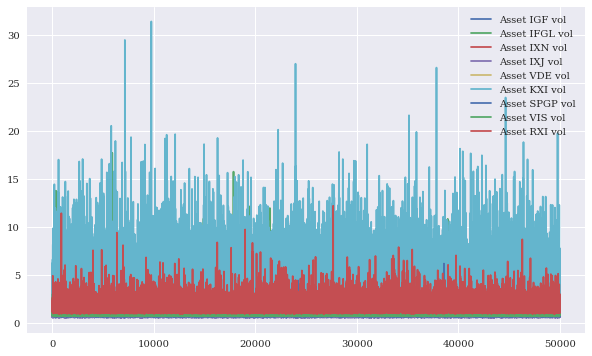

In [87]:
plt.figure(figsize=(10,6))
for i in mylist:
    plt.plot(AVG_VOL['asset_%s' %i], label='Asset %s vol' %i)
plt.legend()
plt.show()

Now We have obtained estimates for the 10-period expected return and variance for each asset.

Assuming constant correlation between the assets, we have obtained a new covariance matrix. And expected return, so we can construct a new effecient portfolio. 

In [88]:
# N-day accumulated return (average):
FHS_mu = pd.DataFrame.from_dict(ACC_RET).mean()/N
#display(FHS_mu)   # compare to rets.mean()

# Daily average volatilty:
FHS_var = pd.DataFrame.from_dict(AVG_VOL).mean()**2
#display(FHS_var)  # compare to rets.var()

In [91]:
FHS_omega = rets.cov()
np.fill_diagonal(FHS_omega.values, FHS_var)
FHS_omega.round(2)

,IGF,IFGL,IXN,IXJ,VDE,KXI,SPGP,VIS,RXI
IGF,1.00,0.52,0.54,0.45,0.67,0.42,0.44,0.51,0.52
IFGL,0.52,6.52,0.57,0.46,0.60,0.42,0.45,0.52,0.56
IXN,0.54,0.57,0.83,0.62,0.77,0.47,0.79,0.76,0.76
IXJ,0.45,0.46,0.62,0.68,0.58,0.42,0.57,0.57,0.57
VDE,0.67,0.60,0.77,0.58,2.31,0.45,0.66,0.83,0.72
KXI,0.42,0.42,0.47,0.42,0.45,20.41,0.40,0.44,0.46
SPGP,0.44,0.45,0.79,0.57,0.66,0.40,0.95,0.66,0.66
VIS,0.51,0.52,0.76,0.57,0.83,0.44,0.66,0.98,0.70
RXI,0.52,0.56,0.76,0.57,0.72,0.46,0.66,0.70,2.94


## FHS based minimum vol portfolio

In [92]:
# a. Find minimum variance weights
FHS_w_min = matrix_optimize.min_vol(noa=noa, omega=FHS_omega)

# b. Compute annualized portfolio return
FHS_ret_min = port_ret(mu=FHS_mu,weights=FHS_w_min)

# c. Compute annualized portfolio volatility
FHS_vol_min = port_vol(omega=FHS_omega,weights=FHS_w_min)

# d. Print results:
print('Minimum vol weights', FHS_w_min)
print('Annualized portfolio return = ', FHS_ret_min.round(3))
print('Annualized portfolio vol = ', FHS_vol_min.round(3))
print('Maximum Sharpe Ratio = ',(FHS_ret_min/FHS_vol_min).round(3),
      '=', -sharpe_ratio(mu=FHS_mu, omega=FHS_omega,weights=FHS_w_min).round(3))

Minimum vol weights [ 0.296  0.024 -0.607  0.615 -0.01   0.009  0.403  0.241  0.029]
Annualized portfolio return =  12.822
Annualized portfolio vol =  11.978
Maximum Sharpe Ratio =  1.07 = 1.07


## FHS efficient portfolio - given target return

In [93]:
# a. Find efficient weights given target return
FHS_w_eff = matrix_optimize.eff_vol(noa=noa, omega=FHS_omega, mu=FHS_mu, target_return=30/252)

# b. Compute annualized portfolio return
FHS_ret_eff = port_ret(mu=FHS_mu, weights=FHS_w_eff)

# c. Compute annualized portfolio volatility
FHS_vol_eff = port_vol(omega=FHS_omega, weights=FHS_w_eff)

# d. Print resuts:
print('Efficient weights', FHS_w_eff)
print('Annualized portfolio return = ', FHS_ret_eff.round(3))
print('Annualized portfolio vol = ', FHS_vol_eff.round(3))
print('Maximum Sharpe Ratio = ',(FHS_ret_eff/FHS_vol_eff).round(3),
      '=', -sharpe_ratio(mu=FHS_mu, omega=FHS_omega,weights=FHS_w_eff).round(3))

Efficient weights [-0.131 -0.012  2.161  0.455 -0.185 -0.027 -0.673 -0.468 -0.119]
Annualized portfolio return =  30.02
Annualized portfolio vol =  17.168
Maximum Sharpe Ratio =  1.749 = 1.749


# Effecient frontier

In [94]:
FHS_z, FHS_front_vol, FHS_front_ret = efficient_frontier(min_weights=FHS_w_min,
                                                   eff_weights=FHS_w_eff, omega=FHS_omega, mu=FHS_mu)

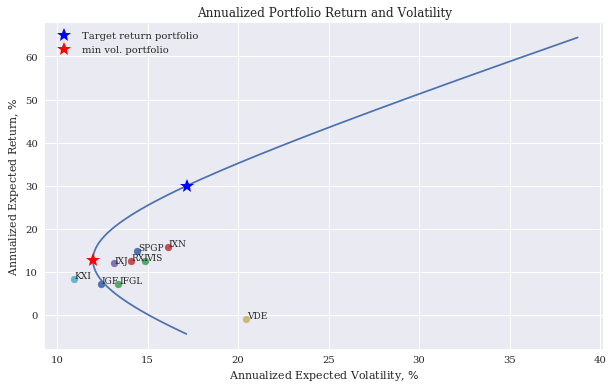

In [95]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

plt.plot(FHS_front_vol, FHS_front_ret)

plt.plot(FHS_vol_eff, FHS_ret_eff, 'b*', markersize=15.0, label='Target return portfolio')
plt.plot(FHS_vol_min, FHS_ret_min, 'r*', markersize=15.0, label='min vol. portfolio')

# plot individual ETFs
for i,type in enumerate(mylist):
    x2 = np.sqrt((rets[type]).var()*252)
    y2 = rets[type].mean()*252
    plt.scatter(x2, y2, marker='o')  
    plt.text(x2+0.05, y2+0.05, type, fontsize=9)
    
plt.xlabel('Annualized Expected Volatility, $\%$')
plt.ylabel('Annualized Expected Return, $\%$')
plt.title('Annualized Portfolio Return and Volatility')

plt.legend()
plt.show()

## Tangent Portfolio

In [96]:
FHS_opt, FHS_evols, FHS_erets, FHS_f_tangent = tangent_portfolio(front_vol=FHS_front_vol, front_ret=FHS_front_ret)

Optimal parameter values =  [ 0.      1.7613 19.7445]
Check that eq holds: [ 0.  0. -0.]


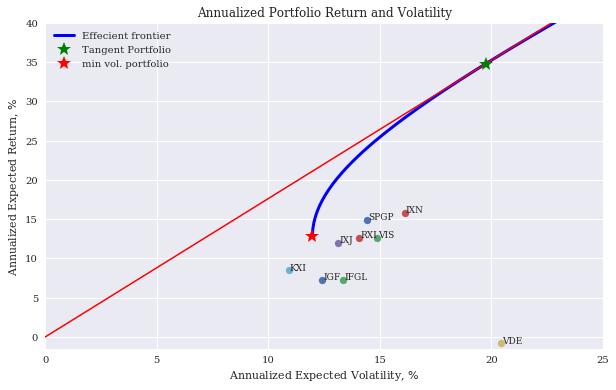

In [98]:
rf=0
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

plt.plot(FHS_evols, FHS_erets, 'b', lw=3.0, label='Effecient frontier')

cx = np.linspace(0.0, 40.0)
plt.plot(cx, FHS_opt[0] + FHS_opt[1] * cx, 'r', lw=1.5)

plt.plot(FHS_opt[2], FHS_f_tangent, 'g*', markersize=15, label='Tangent Portfolio')
plt.plot(FHS_vol_min, FHS_ret_min, 'r*', markersize=15.0, label='min vol. portfolio')

# plot individual ETFs
for i,type in enumerate(mylist):
    x2 = np.sqrt((rets[type]).var()*252)
    y2 = rets[type].mean()*252
    plt.scatter(x2, y2, marker='o')  
    plt.text(x2+0.05, y2+0.05, type, fontsize=9)


plt.grid(True)
axes = plt.gca()
axes.set_xlim([0,25])
axes.set_ylim([-1.5,40])
plt.xlabel('Annualized Expected Volatility, $\%$')
plt.ylabel('Annualized Expected Return, $\%$')
plt.title('Annualized Portfolio Return and Volatility')
plt.legend()

plt.savefig('tangent_port.png', dpi=300, bbox_inches='tight')

In [99]:
# a. Find tangent portfolio weight
ind = np.where(np.array(FHS_front_vol.round(1)==FHS_opt[2].round(1)))[0][0]
FHS_w_tan = FHS_z[ind]

# b. Compute annualized portfolio return
FHS_ret_tan = port_ret(mu=FHS_mu,weights=FHS_w_tan)

# c. Compute annualized portfolio volatility
FHS_vol_tan = port_vol(omega=FHS_omega,weights=FHS_w_tan)

# d. Print resuts:
print('Efficient weights', FHS_w_tan.round(3))
print('Annualized portfolio return = ', FHS_ret_tan.round(3))
print('Annualized portfolio vol = ', FHS_vol_tan.round(3))
print('Maximum Sharpe Ratio = ',(FHS_ret_tan/FHS_vol_tan).round(3),
      '=', -sharpe_ratio(mu=FHS_mu, omega=FHS_omega,weights=FHS_w_tan).round(3))

Efficient weights [-0.247 -0.022  2.912  0.412 -0.232 -0.037 -0.965 -0.66  -0.159]
Annualized portfolio return =  34.686
Annualized portfolio vol =  19.694
Maximum Sharpe Ratio =  1.761 = 1.761



# Conclusion

In [102]:
# Weights: minimum vol, max Sharpe
conc_2 = np.vstack([mylist, FHS_w_min.round(3)])
conc_2 = np.vstack([conc_2, FHS_w_eff.round(3)])
conc_2 = np.vstack([conc_2, FHS_w_tan.round(3)])

# Portfolio return
P_R_2 = np.ones(4)
P_R_2[1:] = np.array([FHS_ret_min , FHS_ret_eff, FHS_ret_tan]).round(3)
conc_2 = np.column_stack((conc_2, P_R_2))

# Portfolio volatility
P_V_2 = np.ones(4)
P_V_2[1:] = np.array([FHS_vol_min , FHS_vol_eff, FHS_vol_tan]).round(3)
conc_2 = np.column_stack((conc_2, P_V_2))

# Portfolio Sharpe Ratio
P_SR_2 = np.ones(4)
P_SR_2[1:] = np.array([-sharpe_ratio(mu=FHS_mu, omega=FHS_omega,weights=FHS_w_min),
                       -sharpe_ratio(mu=FHS_mu, omega=FHS_omega,weights=FHS_w_eff), 
                       -sharpe_ratio(mu=FHS_mu, omega=FHS_omega,weights=FHS_w_tan)]).round(3)
conc_2 = np.column_stack((conc_2, P_SR_2))

conc_2 = pd.DataFrame(conc_2, index=['FHS', 'Minimum vol. portfolio', 
                                     'Target return portfolio', 'Tangent portfolio'])


conc_2.columns = conc_2.iloc[0]
conc_2 = conc_2.drop(conc_2.index[0])
conc_2.columns.values[[-3, -2, -1]] = ['Exp. return', 'Exp. volatility', 'Exp. SR']
conc_2

FHS,IGF,IFGL,IXN,IXJ,VDE,KXI,SPGP,VIS,RXI,Exp. return,Exp. volatility,Exp. SR
Minimum vol. portfolio,0.296,0.024,-0.607,0.615,-0.01,0.009,0.403,0.241,0.029,12.822,11.978,1.07
Target return portfolio,-0.131,-0.012,2.161,0.455,-0.185,-0.027,-0.673,-0.468,-0.119,30.02,17.168,1.749
Tangent portfolio,-0.247,-0.022,2.912,0.412,-0.232,-0.037,-0.965,-0.66,-0.159,34.686,19.694,1.761


# Backtest

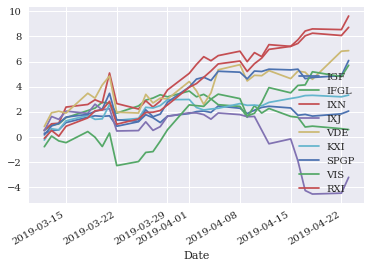

In [105]:
train, test = rets[:-n_time], rets[-n_time : H]
test.cumsum().plot()

In [140]:
#Test period accumulated return
hist_perform_ret = hist_w_tan.dot(test.cumsum().iloc[-1])
print('Hist portfolio acc. return = ',hist_perform_ret*1/(n_time/252))

FHS_perform_ret = FHS_w_tan.dot(test.cumsum().iloc[-1])
print('FHS portfolio acc. return = ',FHS_perform_ret*1/(n_time/252))

Hist portfolio acc. return =  11.571274359634906
FHS portfolio acc. return =  33.82134950617678


In [141]:
hist_w_tan.dot(test.cov().dot(hist_w_tan))

0.9019729718735479

In [142]:
FHS_w_tan.dot(test.cov().dot(FHS_w_tan))

2.445044649865104